#Multilayer Perceptron (MLP)

In this lesson, we will explore multilayer perceptrons (MLPs) which are a basic type of neural network. We'll first motivate non-linear activation functions by trying to fit a linear model (logistic regression) on our non-linear spiral data. Then we'll implement an MLP using just NumPy and then with PyTorch.

<div align="left">
<a href="https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_PT_Multilayer_Perceptrons.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_PT_Multilayer_Perceptrons.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Overview

Our goal is to learn a model  𝑦̂   that models  𝑦  given  𝑋 . You'll notice that neural networks are just extensions of the generalized linear methods we've seen so far but with non-linear activation functions since our data will be highly non-linear.

<div align="left">
<img src="https://raw.githubusercontent.com/madewithml/images/master/basics/09_Multilayer_Perceptron/nn.png" width="550">
</div>

$z_1 = XW_1$

$a_1 = f(z_1)$

$z_2 = a_1W_2$

$\hat{y} = softmax(z_2)$ # classification

* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W_1$ = 1st layer weights | $\in \mathbb{R}^{DXH}$ ($H$ is the number of hidden units in layer 1)
* $z_1$ = outputs from first layer  $\in \mathbb{R}^{NXH}$
* $f$ = non-linear activation function
* $a_1$ = activation applied first layer's outputs | $\in \mathbb{R}^{NXH}$
* $W_2$ = 2nd layer weights | $\in \mathbb{R}^{HXC}$ ($C$ is the number of classes)
* $z_2$ = outputs from second layer  $\in \mathbb{R}^{NXH}$
* $\hat{y}$ = prediction | $\in \mathbb{R}^{NXC}$ ($N$ is the number of samples)

* **Objective:**  Predict the probability of class $y$ given the inputs $X$. Non-linearity is introduced to model the complex, non-linear data.
* **Advantages:**
  * Can model non-linear patterns in the data really well.
* **Disadvantages:**
  * Overfits easily.
  * Computationally intensive as network increases in size.
  * Not easily interpretable.
* **Miscellaneous:** Future neural network architectures that we'll see use the MLP as a modular unit for feed forward operations (affine transformation (XW) followed by a non-linear operation).

**Note**: We're going to leave out the bias terms $\beta$ to avoid further crowding the backpropagation calculations.

# Data

## Load data

Download non-linear spiral data for a classification task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [2]:
SEED = 1234
DATA_FILE = "spiral.csv"

In [3]:
# Set seed for reproducibility
np.random.seed(SEED)

In [4]:
DATA_FILE = '/Users/elena/Documents/Projects/reviews/data/spiral.csv'

In [59]:
def spiral_xy(i, spiral_num):
    """
    Create the data for a spiral.

    Arguments:
        i runs from 0 to 96
        spiral_num is 1 or -1
    """
    φ = i/16 * math.pi
    r = 6.5 * ((104 - i)/104)
    x = (r * math.cos(φ) * spiral_num)/13 + 0.5
    y = (r * math.sin(φ) * spiral_num)/13 + 0.5
    return (x, y)

def spiral(spiral_num):
    return [spiral_xy(i, spiral_num) for i in range(500)]

In [43]:
import math
N=1000
df=pd.DataFrame(spiral(N)).rename(columns={'0':'X1','1':'X2'})


In [66]:
a = ["A", spiral(1)]
b = ["B", spiral(-1)]

df1=pd.DataFrame(spiral(1)).rename(columns={0:'X1',1:'X2'})
df1['color']='red'
df2=pd.DataFrame(spiral(-1)).rename(columns={0:'X1',1:'X2'})
df2['color']='yellow'
df=df1.append(df2)

In [117]:
from sklearn.datasets import make_moons, make_circles, make_classification

# Load data
#df = pd.read_csv(DATA_FILE, sep="\t",header=0).rename(columns={'x':'X1','y':'X2'})

m=make_moons(1000)
df=pd.DataFrame(m[0]).rename(columns={0:'X1',1:'X2'})
df['color']=pd.Series(m[1])
df

X = df[['X1', 'X2']].values
y = df['color'].values
df.head(5)

,X1,X2,color
0,-0.999683,0.025180,0
1,-0.998395,0.056632,0
2,0.015739,0.999876,0
3,0.471208,-0.348752,1
4,0.621378,0.783511,0


In [118]:
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1000, 2)
y:  (1000,)


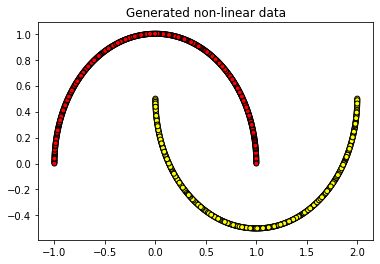

In [120]:
# Visualize data
plt.title("Generated non-linear data")
colors = {0: 'red', 1: 'yellow'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors='k', s=25)
plt.show()

## Split data

In [121]:
import collections
from sklearn.model_selection import train_test_split

In [122]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [123]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [124]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (722, 2), y_train: (722,)
X_val: (128, 2), y_val: (128,)
X_test: (150, 2), y_test: (150,)
Sample point: [-0.71485433  0.6992734 ] → 0
Classes: {0: 500, 1: 500}


## Label encoder

In [125]:
from sklearn.preprocessing import LabelEncoder

In [126]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [127]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: [0, 1]


In [128]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: 0
y_train[0]: 0


In [129]:
# Class weights
counts = collections.Counter(y_train)
class_weights = {_class: 1.0/count for _class, count in counts.items()}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: Counter({0: 361, 1: 361}),
class weights: {0: 0.002770083102493075, 1: 0.002770083102493075}


## Standardize data

We need to standardize our data (zero mean and unit variance) in order to optimize quickly. We're only going to standardize the inputs X because out outputs y are class values.

In [130]:
from sklearn.preprocessing import StandardScaler

In [131]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [132]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [133]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train[0]: mean: {np.mean(X_train[:, 0], axis=0):.1f}, std: {np.std(X_train[:, 0], axis=0):.1f}")
print (f"X_train[1]: mean: {np.mean(X_train[:, 1], axis=0):.1f}, std: {np.std(X_train[:, 1], axis=0):.1f}")
print (f"X_val[0]: mean: {np.mean(X_val[:, 0], axis=0):.1f}, std: {np.std(X_val[:, 0], axis=0):.1f}")
print (f"X_val[1]: mean: {np.mean(X_val[:, 1], axis=0):.1f}, std: {np.std(X_val[:, 1], axis=0):.1f}")
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_train[0]: mean: -0.0, std: 1.0
X_train[1]: mean: -0.0, std: 1.0
X_val[0]: mean: -0.1, std: 1.0
X_val[1]: mean: -0.1, std: 1.0
X_test[0]: mean: 0.0, std: 1.0
X_test[1]: mean: -0.2, std: 0.9


# Linear model

Before we get to our neural network, we're going to motivate non-linear activation functions by implementing a generalized linear model (logistic regression). We'll see why linear models (with linear activations) won't suffice for our dataset.

In [134]:
import torch

In [135]:
# Set seed for reproducibility
torch.manual_seed(SEED)

## Model

In [136]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [137]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = len(classes) # 3 classes

In [138]:
INPUT_DIM,NUM_CLASSES

(2, 2)

In [139]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x_in, apply_softmax=False):
        z = self.fc1(x_in) # linear activation
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [140]:
# Initialize model
model = LinearModel(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)
summary(model, input_size=(INPUT_DIM,))

<bound method Module.named_parameters of LinearModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             300
            Linear-2                    [-1, 2]             202
Total params: 502
Trainable params: 502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Training

In [141]:
from torch.optim import Adam

In [142]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [144]:
# Loss
weights = torch.Tensor([class_weights[key] for key in sorted(class_weights.keys())])
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [145]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [146]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

In [147]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [148]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%1==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.75, accuracy: 50.0
Epoch: 1 | loss: 0.44, accuracy: 84.1
Epoch: 2 | loss: 0.30, accuracy: 89.1
Epoch: 3 | loss: 0.25, accuracy: 88.4
Epoch: 4 | loss: 0.24, accuracy: 88.2
Epoch: 5 | loss: 0.24, accuracy: 88.4
Epoch: 6 | loss: 0.24, accuracy: 88.5
Epoch: 7 | loss: 0.25, accuracy: 88.8
Epoch: 8 | loss: 0.25, accuracy: 88.9
Epoch: 9 | loss: 0.25, accuracy: 89.2


## Evaluation

In [149]:
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [150]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

In [151]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [152]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([9.9970e-01, 2.9527e-04], grad_fn=<SelectBackward>)
sample class: 0


In [153]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.89, test acc: 0.85


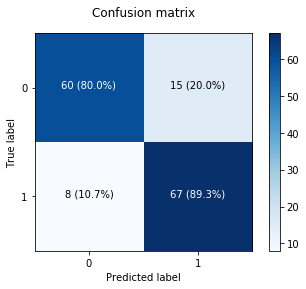

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        75
           1       0.82      0.89      0.85        75

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150



In [154]:
# Metrics
plot_confusion_matrix(y_test, pred_test, classes=classes)
print (classification_report(y_test, pred_test))

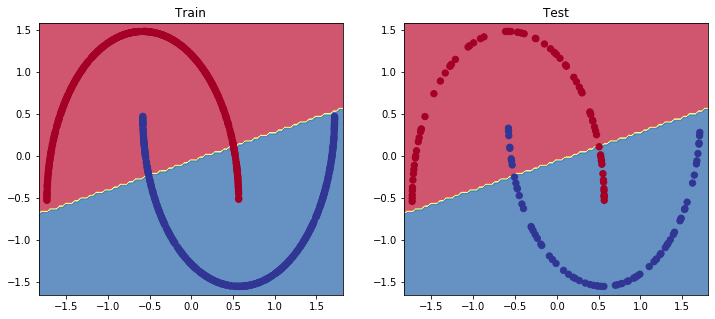

In [155]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

# Activation functions

Using the generalized linear method (logistic regression) yielded poor results because of the non-linearity present in our data yet our activation functions were linear. We need to use an activation function that can allow our model to learn and map the non-linearity in our data. There are many different options so let's explore a few.

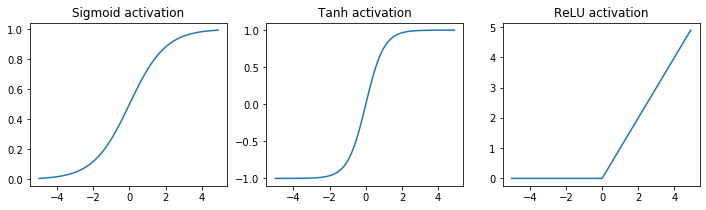

In [156]:
# Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu (clip the negative values to 0)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()

The ReLU activation function ($max(0,z)$) is by far the most widely used activation function for neural networks. But as you can see, each activation function has its own constraints so there are circumstances where you'll want to use different ones. For example, if we need to constrain our outputs between 0 and 1, then the sigmoid activation is the best choice.

**NOTE**: In some cases, using a ReLU activation function may not be sufficient. For instance, when the outputs from our neurons are mostly negative, the activation function will produce zeros. This effectively creates a "dying ReLU" and a recovery is unlikely. To mitigate this effect, we could lower the learning rate or use [alternative ReLU activations](https://medium.com/tinymind/a-practical-guide-to-relu-b83ca804f1f7), ex. leaky ReLU or parametric ReLU (PReLU), which have a small slope for negative neuron outputs. 

# NumPy

Now let's create our multilayer perceptron (MLP) which is going to be exactly like the logistic regression model but with the activation function to map the non-linearity in our data. 

**NOTE**: It's normal to find the math and code in this section slightly complex. You can still read each of the steps to build intuition for when we implement this using PyTorch.


Our goal is to learn a model  𝑦̂   that models  𝑦  given  𝑋 . You'll notice that neural networks are just extensions of the generalized linear methods we've seen so far but with non-linear activation functions since our data will be highly non-linear.

$z_1 = XW_1$

$a_1 = f(z_1)$

$z_2 = a_1W_2$

$\hat{y} = softmax(z_2)$ # classification

* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W_1$ = 1st layer weights | $\in \mathbb{R}^{DXH}$ ($H$ is the number of hidden units in layer 1)
* $z_1$ = outputs from first layer  $\in \mathbb{R}^{NXH}$
* $f$ = non-linear activation function
* $a_1$ = activation applied first layer's outputs | $\in \mathbb{R}^{NXH}$
* $W_2$ = 2nd layer weights | $\in \mathbb{R}^{HXC}$ ($C$ is the number of classes)
* $z_2$ = outputs from second layer  $\in \mathbb{R}^{NXH}$
* $\hat{y}$ = prediction | $\in \mathbb{R}^{NXC}$ ($N$ is the number of samples)

## Initialize weights

1. Randomly initialize the model's weights $W$ (we'll cover more effective initialization strategies later in this lesson).

In [157]:
# Initialize first layer's weights
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1 = np.zeros((1, HIDDEN_DIM))
print (f"W1: {W1.shape}")
print (f"b1: {b1.shape}")

W1: (2, 100)
b1: (1, 100)


## Model

2. Feed inputs $X$ into the model to do the forward pass and receive the probabilities.

First we pass the inputs into the first layer.
  * $z_1 = XW_1$

In [158]:
# z1 = [NX2] · [2X100] + [1X100] = [NX100]
z1 = np.dot(X_train, W1) + b1
print (f"z1: {z1.shape}")

z1: (722, 100)


Next we apply the non-linear activation function, ReLU ($max(0,z)$) in this case.
  * $a_1 = f(z_1)$

In [159]:
# Apply activation function
a1 = np.maximum(0, z1) # ReLU
print (f"a_1: {a1.shape}")

a_1: (722, 100)


We pass the activations to the second layer to get our logits.
  * $z_2 = a_1W_2$

In [160]:
# Initialize second layer's weights
W2 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2 = np.zeros((1, NUM_CLASSES))
print (f"W2: {W2.shape}")
print (f"b2: {b2.shape}")

W2: (100, 2)
b2: (1, 2)


In [161]:
# z2 = logits = [NX100] · [100X3] + [1X3] = [NX3]
logits = np.dot(a1, W2) + b2
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (722, 2)
sample: [ 9.50936027e-04 -6.77234136e-05]


We'll apply the softmax function to normalize the logits and btain class probabilities.
  * $\hat{y} = softmax(z_2)$

In [162]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (722, 2)
sample: [0.50025466 0.49974534]


## Loss

3. Compare the predictions $\hat{y}$ (ex.  [0.3, 0.3, 0.4]]) with the actual target values $y$ (ex. class 2 would look like [0, 0, 1]) with the objective (cost) function to determine loss $J$. A common objective function for classification tasks is cross-entropy loss. 
  * $J(\theta) = - \sum_i ln(\hat{y_i}) = - \sum_i ln (\frac{e^{X_iW_y}}{\sum_j e^{X_iW}}) $

In [163]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)

## Gradients

4. Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights. 

The gradient of the loss w.r.t to W2 is the same as the gradients from logistic regression since $\hat{y} = softmax(z_2)$.
 * $\frac{\partial{J}}{\partial{W_{2j}}} = \frac{\partial{J}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{W_{2j}}} = - \frac{1}{\hat{y}}\frac{\partial{\hat{y}}}{\partial{W_{2j}}} = - \frac{1}{\frac{e^{W_{2y}a_1}}{\sum_j e^{a_1W}}}\frac{\sum_j e^{a_1W}e^{a_1W_{2y}}0 - e^{a_1W_{2y}}e^{a_1W_{2j}}a_1}{(\sum_j e^{a_1W})^2} = \frac{a_1e^{a_1W_{2j}}}{\sum_j e^{a_1W}} = a_1\hat{y}$
  * $\frac{\partial{J}}{\partial{W_{2y}}} = \frac{\partial{J}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{W_{2y}}} = - \frac{1}{\hat{y}}\frac{\partial{\hat{y}}}{\partial{W_{2y}}} = - \frac{1}{\frac{e^{W_{2y}a_1}}{\sum_j e^{a_1W}}}\frac{\sum_j e^{a_1W}e^{a_1W_{2y}}a_1 - e^{a_1W_{2y}}e^{a_1W_{2y}}a_1}{(\sum_j e^{a_1W})^2} = \frac{1}{\hat{y}}(a_1\hat{y} - a_1\hat{y}^2) = a_1(\hat{y}-1)$

  The gradient of the loss w.r.t W1 is a bit trickier since we have to backpropagate through two sets of weights.
  * $ \frac{\partial{J}}{\partial{W_1}} = \frac{\partial{J}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{a_1}}  \frac{\partial{a_1}}{\partial{z_1}}  \frac{\partial{z_1}}{\partial{W_1}}  = W_2(\partial{scores})(\partial{ReLU})X $

In [164]:
# dJ/dW2
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW2 = np.dot(a1.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

In [165]:
# dJ/dW1
dhidden = np.dot(dscores, W2.T)
dhidden[a1 <= 0] = 0 # ReLu backprop
dW1 = np.dot(X_train.T, dhidden)
db1 = np.sum(dhidden, axis=0, keepdims=True)

## Update weights

5. Update the weights $W$ using a small learning rate $\alpha$. The updates will penalize the probabiltiy for the incorrect classes (j) and encourage a higher probability for the correct class (y).
  * $W_i = W_i - \alpha\frac{\partial{J}}{\partial{W_i}}$

In [166]:
# Update weights
W1 += -LEARNING_RATE * dW1
b1 += -LEARNING_RATE * db1
W2 += -LEARNING_RATE * dW2
b2 += -LEARNING_RATE * db2

## Training

6. Repeat steps 2 - 4 until model performs well.

In [167]:
# Convert tensors to NumPy arrays
X_train = X_train.numpy()
y_train = y_train.numpy()
X_val = X_val.numpy()
y_val = y_val.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [168]:
# Initialize random weights
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1 = np.zeros((1, HIDDEN_DIM))
W2 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2 = np.zeros((1, NUM_CLASSES))

# Training loop
for epoch_num in range(1000):

    # First layer forward pass [NX2] · [2X100] = [NX100]
    z1 = np.dot(X_train, W1) + b1

    # Apply activation function
    a1 = np.maximum(0, z1) # ReLU

    # z2 = logits = [NX100] · [100X3] = [NX3]
    logits = np.dot(a1, W2) + b2
    
    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%100 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # dJ/dW2
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW2 = np.dot(a1.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # dJ/dW1
    dhidden = np.dot(dscores, W2.T)
    dhidden[a1 <= 0] = 0 # ReLu backprop
    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)

    # Update weights
    W1 += -1e0 * dW1
    b1 += -1e0 * db1
    W2 += -1e0 * dW2
    b2 += -1e0 * db2

Epoch: 0, loss: 0.694, accuracy: 0.500
Epoch: 100, loss: 0.225, accuracy: 0.895
Epoch: 200, loss: 0.135, accuracy: 0.939
Epoch: 300, loss: 0.022, accuracy: 1.000
Epoch: 400, loss: 0.009, accuracy: 1.000
Epoch: 500, loss: 0.005, accuracy: 1.000
Epoch: 600, loss: 0.004, accuracy: 1.000
Epoch: 700, loss: 0.003, accuracy: 1.000
Epoch: 800, loss: 0.002, accuracy: 1.000
Epoch: 900, loss: 0.002, accuracy: 1.000


In [169]:
class MLPFromScratch():
    def predict(self, x):
        z1 = np.dot(x, W1) + b1
        a1 = np.maximum(0, z1)
        logits = np.dot(a1, W2) + b2
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat

In [170]:
# Evaluation
model = MLPFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)

In [171]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 1.00, test acc: 1.00


In [172]:
def plot_multiclass_decision_boundary_numpy(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format='png')

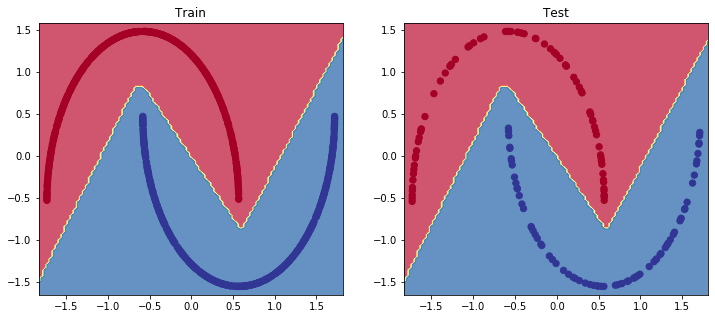

In [173]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary_numpy(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary_numpy(model=model, X=X_test, y=y_test)
plt.show()

Credit for the plotting functions and the intuition behind all this is due to [CS231n](http://cs231n.github.io/neural-networks-case-study/), one of the best courses for machine learning. Now let's implement the MLP with PyTorch.

# MLP

## Model

In [0]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) # ReLU activaton function added!
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [70]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)
summary(model, input_size=(INPUT_DIM,))

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             300
            Linear-2                    [-1, 3]             303
Total params: 603
Trainable params: 603
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Training

In [0]:
# Loss
weights = torch.Tensor([class_weights[key] for key in sorted(class_weights.keys())])
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [0]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [0]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

In [0]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [77]:
# Training
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.09, accuracy: 21.3
Epoch: 10 | loss: 0.66, accuracy: 58.1
Epoch: 20 | loss: 0.49, accuracy: 72.1
Epoch: 30 | loss: 0.37, accuracy: 89.2
Epoch: 40 | loss: 0.27, accuracy: 91.4
Epoch: 50 | loss: 0.21, accuracy: 93.5
Epoch: 60 | loss: 0.16, accuracy: 95.2
Epoch: 70 | loss: 0.14, accuracy: 95.8
Epoch: 80 | loss: 0.11, accuracy: 96.8
Epoch: 90 | loss: 0.10, accuracy: 97.9


## Evaluation

In [78]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([6.8674e-03, 7.5599e-04, 9.9238e-01], grad_fn=<SelectBackward>)
sample class: 2


In [79]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.98, test acc: 0.99


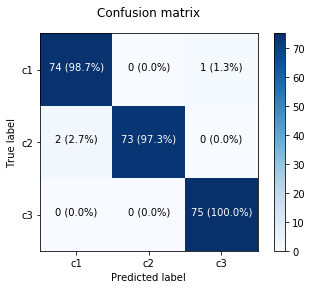

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        75
           1       1.00      0.97      0.99        75
           2       0.99      1.00      0.99        75

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



In [80]:
# Metrics
plot_confusion_matrix(y_test, pred_test, classes=classes)
print (classification_report(y_test, pred_test))

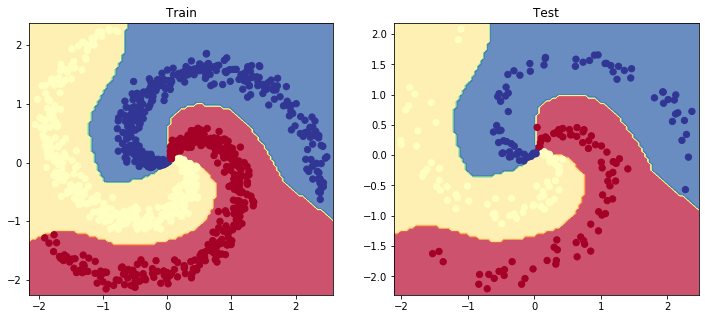

In [81]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

## Inference

In [82]:
# Inputs for inference
X_infer = pd.DataFrame([{'X1': 0.1, 'X2': 0.1}])
X_infer.head()

,X1,X2
0,0.1,0.1


In [83]:
# Standardize
X_infer = X_scaler.transform(X_infer)
print (X_infer)

[[0.30945845 0.30761858]]


In [84]:
# Predict
y_infer = model(torch.Tensor(X_infer), apply_softmax=True)
prob, _class = y_infer.max(dim=1)
print (f"The probability of class {classes[_class.detach().numpy()[0]]} is {prob.detach().numpy()[0]*100.0:.0f}%")

The probability of class c1 is 96%


# Initializing weights

So far we have been initializing weights with small random values and this isn't optimal for convergence during training. The objective is to have weights that are able to produce outputs that follow a similar distribution across all neurons. We can do this by enforcing weights to have unit variance prior the affine and non-linear operations.

**NOTE**: A popular method is to apply [xavier initialization](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization), which essentially initializes the weights to allow the signal from the data to reach deep into the network. You may be wondering why we don't do this for every forward pass and that's a great question. We'll look at more advanced strategies that help with optimization like batch/layer normalization, etc. in future lessons. Meanwhile you can check out other initializers [here](https://pytorch.org/docs/stable/nn.init.html).

In [0]:
from torch.nn import init

In [0]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=init.calculate_gain('relu')) 
        
    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) # ReLU activaton function added!
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

# Dropout

A great technique to have our models generalize (perform well on test data) is to increase the size of your data but this isn't always an option. Fortuntely, there are methods like regularization and dropout that can help create a more robust model. 

Dropout is a technique (used only during training) that allows us to zero the outputs of neurons. We do this for `dropout_p`% of the total neurons in each layer and it changes every batch. Dropout prevents units from co-adapting too much to the data and acts as a sampling strategy since we drop a different set of neurons each time.

<div align="left">
<img src="https://raw.githubusercontent.com/madewithml/images/master/basics/09_Multilayer_Perceptron/dropout.png" width="350">
</div>

* [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

In [0]:
DROPOUT_P = 0.1 # % of the neurons that are dropped each pass

In [0]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p) # dropout
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=init.calculate_gain('relu')) 
        
    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in)) 
        z = self.dropout(z) # dropout
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [89]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, 
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
print (model.named_parameters)
summary(model, input_size=(INPUT_DIM,))

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             300
           Dropout-2                  [-1, 100]               0
            Linear-3                    [-1, 3]             303
Total params: 603
Trainable params: 603
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Overfitting

Though neural networks are great at capturing non-linear relationships they are highly susceptible to overfitting to the training data and failing to generalize on test data. Just take a look at the example below where we generate completely random data and are able to fit a model with [$2*N*C + D$](https://arxiv.org/abs/1611.03530) hidden units. The training performance is good (~70%) but the overfitting leads to very poor test performance. We'll be covering strategies to tackle overfitting in future lessons.

In [0]:
NUM_EPOCHS = 500
NUM_SAMPLES_PER_CLASS = 50
LEARNING_RATE = 1e-1
HIDDEN_DIM = 2 * NUM_SAMPLES_PER_CLASS * NUM_CLASSES + INPUT_DIM # 2*N*C + D

In [140]:
# Generate random data
X = np.random.rand(NUM_SAMPLES_PER_CLASS * NUM_CLASSES, INPUT_DIM)
y = np.array([[i]*NUM_SAMPLES_PER_CLASS for i in range(NUM_CLASSES)]).reshape(-1)
print ("X: ", format(np.shape(X)))
print ("y: ", format(np.shape(y)))

X:  (150, 2)
y:  (150,)


In [141]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
print ("X_train:", X_train.shape)
print ("y_train:", y_train.shape)
print ("X_val:", X_val.shape)
print ("y_val:", y_val.shape)
print ("X_test:", X_test.shape)
print ("y_test:", y_test.shape)

X_train: (107, 2)
y_train: (107,)
X_val: (20, 2)
y_val: (20,)
X_test: (23, 2)
y_test: (23,)


In [0]:
# Standardize the inputs (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [0]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [144]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, 
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
print (model.named_parameters)
summary(model, input_size=(INPUT_DIM,))

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=302, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=302, out_features=3, bias=True)
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 302]             906
           Dropout-2                  [-1, 302]               0
            Linear-3                    [-1, 3]             909
Total params: 1,815
Trainable params: 1,815
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [0]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

In [146]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%20==0: 
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.12, accuracy: 34.6
Epoch: 20 | loss: 1.07, accuracy: 38.3
Epoch: 40 | loss: 1.01, accuracy: 48.6
Epoch: 60 | loss: 0.98, accuracy: 53.3
Epoch: 80 | loss: 0.97, accuracy: 53.3
Epoch: 100 | loss: 0.97, accuracy: 52.3
Epoch: 120 | loss: 0.91, accuracy: 58.9
Epoch: 140 | loss: 0.93, accuracy: 56.1
Epoch: 160 | loss: 0.94, accuracy: 53.3
Epoch: 180 | loss: 0.89, accuracy: 56.1
Epoch: 200 | loss: 0.93, accuracy: 57.0
Epoch: 220 | loss: 0.94, accuracy: 51.4
Epoch: 240 | loss: 0.90, accuracy: 57.0
Epoch: 260 | loss: 0.96, accuracy: 53.3
Epoch: 280 | loss: 0.94, accuracy: 55.1
Epoch: 300 | loss: 0.85, accuracy: 57.9
Epoch: 320 | loss: 0.87, accuracy: 59.8
Epoch: 340 | loss: 0.86, accuracy: 60.7
Epoch: 360 | loss: 0.85, accuracy: 60.7
Epoch: 380 | loss: 0.86, accuracy: 53.3
Epoch: 400 | loss: 0.86, accuracy: 61.7
Epoch: 420 | loss: 0.90, accuracy: 56.1
Epoch: 440 | loss: 0.89, accuracy: 53.3
Epoch: 460 | loss: 0.82, accuracy: 62.6
Epoch: 480 | loss: 0.86, accuracy: 58.9


In [147]:
# Predictions
pred_train = model(X_train, apply_softmax=True)
pred_test = model(X_test, apply_softmax=True)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([0.0514, 0.1081, 0.8405], grad_fn=<SelectBackward>)
sample class: 2


In [148]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.63, test acc: 0.26


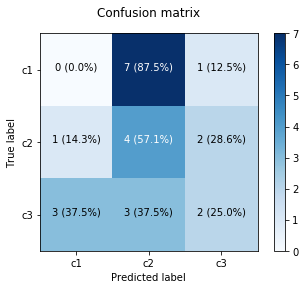

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.29      0.57      0.38         7
           2       0.40      0.25      0.31         8

    accuracy                           0.26        23
   macro avg       0.23      0.27      0.23        23
weighted avg       0.23      0.26      0.22        23



In [149]:
# Classification report
plot_confusion_matrix(y_true=y_test, y_pred=pred_test, classes=classes)
print (classification_report(y_test, pred_test))

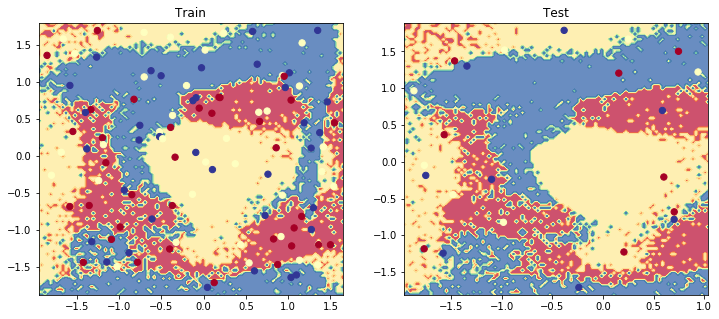

In [150]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

It's important that we experiment, starting with simple models that underfit (high bias) and improve it towards a good fit. Starting with simple models (linear/logistic regression) let's us catch errors without the added complexity of more sophisticated models (neural networks). 

<div align="left">
<img src="https://raw.githubusercontent.com/madewithml/images/master/basics/09_Multilayer_Perceptron/fit.png" width="700">
</div>

---
Share and discover ML projects at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/basics"><img src="https://img.shields.io/github/stars/madewithml/basics.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             